In [1]:
!pip install deep_utils
!pip install opencv-python

In [2]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from IPython.core.display import HTML
import tensorflow as tf
import torch
from deep_utils import stratify_train_test_split_multi_label
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
f = open('data/train.txt')
train_data = f.readlines()

f = open('data/test.txt')
test_data = f.readlines()

## 📌  Raw Data 전처리
> 대회에서 제공한 train/text 데이터를 학습할 데이터를 생성하기 용이한 형태로 변경하는 단계입니다.
1. ```Input``` : raw train, text 데이터
2. ```Output``` : ner tag가 제거된 text, text에 포함된 entity/tag리스트, entity 개수 

In [4]:
def preprocess_text(line):
    entities, tags = [], []
    l = re.findall(r'<[%-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·\s0-9ㄱ-ㅣ가-힣A-Za-z]+:[A-Za-z]+>', line)
    
    for label in l:
        entity, tag = label.replace('<', '').replace('>','').split(':')
        entities.append(entity)
        tags.append(tag)
        line = line.replace('\n', '').replace(label, entity)
    
    return line, entities, tags

In [5]:
def prepare_df(data):
    preprocessed_text, entities, tags, counts = [], [], [], []
    
    for line in data:
        line, entity, tag = preprocess_text(line)
        preprocessed_text.append(line)
        entities.append(entity)
        tags.append(tag)
        counts.append(len(entity))
    
    df = pd.DataFrame({"text": data, 'preprocessed_text': preprocessed_text, 'entities': entities, 'tags': tags, 'cnt': counts})
    return df

In [6]:
train_df = prepare_df(train_data)
test_df = prepare_df(test_data)

In [7]:
train_df["id"] = train_df.index

In [8]:
train_df.head()

,text,preprocessed_text,entities,tags,cnt,id
0,아름다운 <첫걸음:QT> . 과정없이 자라는 나무는 없어요~\n,아름다운 첫걸음 . 과정없이 자라는 나무는 없어요~,[첫걸음],[QT],1,0
1,TV상영종료후 <1년뒤:DT>에 극장판이 나올정도의 초 대작.TV편의 설정오류 수정...,TV상영종료후 1년뒤에 극장판이 나올정도의 초 대작.TV편의 설정오류 수정과 새로운...,[1년뒤],[DT],1,1
2,"지루할 틈없이 웃음포인트들이 있고, <4년전:DT> 영화지만 지금:봐도 재미있네요\n","지루할 틈없이 웃음포인트들이 있고, 4년전 영화지만 지금:봐도 재미있네요",[4년전],[DT],1,2
3,<고3:QT>때 개봉날 극장서 봤는데 당시 엄청 감동이였음.같이 본 여자애들 울고 ...,고3때 개봉날 극장서 봤는데 당시 엄청 감동이였음.같이 본 여자애들 울고 그랬어요.,[고3],[QT],1,3
4,눈물 펑펑 역시 <병만:PS>삼촌은 기대를 져버리지 않았슴다!\n,눈물 펑펑 역시 병만삼촌은 기대를 져버리지 않았슴다!,[병만],[PS],1,4


# 💡 학습 데이터 - 검증 데이터 분리

> [**deep_utils**](https://github.com/pooya-mohammadi/deep_utils)  패키지에서  `stratify_train_test_split_multi_label`을 활용하여 데이터의 분포를 유지하면서 **train:val=8:2** 비율로 분리했습니다. 분리 비율은 `test_size`를 통해 조절 가능합니다.  

- NER task에서 train:val 데이터를 분리할 때 고려해야 되는 점은 2가지가 있습니다.  
    **① 각 데이터에 포함된 태그의 분포**: 학습 과정에서 학습한 내용에 대한 정확한 검증을 위해선 두 데이터 간 태그 분포가 유사해야 합니다.  
    **② 각 데이터에 포함된 태그 개수의 분포**: 데이터에 포함된 태그의 분포가 유사하더라도 각 데이터에 포함된 태그 개수의 분포는 다를 수 있습니다. 일례로 PS 태그가 하나 포함된 데이터가 10개 있는 데이터와 PS 태그가 10개 포함된 데이터가 1개 있는 데이터의 태그 분포는 동일하지만 태그 개수 분포는 전혀 달라집니다. 이러한 차이는 학습시 방해 요소가 될 수 있으므로 태그 분포와 함께 태그 개수의 분포도 고려하여 분리해야 합니다.
    
- 저희는 `stratify_train_test_split_multi_label`를 이용해 train 데이터와 validation 데이터 간 **(1) 태그 분포 (2) 태그 개수 분포**를 최대한 동일하게 유지하며 분리할 수 있습니다.

In [9]:
tags = ['PS', 'LC', 'OG', 'DT', 'TI', 'QT']

def convert_tags_to_vector(tags):
    labels = [0]*6
    for tag in tags:
        if tag == 'QT':
            labels[0] += 1
        if tag == 'DT':
            labels[1] += 1
        if tag == 'PS':
            labels[2] += 1
        if tag == 'LC':
            labels[3] += 1
        if tag == 'TI':
            labels[4] += 1
        if tag == 'OG':
            labels[5] += 1
    return labels

In [10]:
train_df["y"] = train_df["tags"].apply(lambda x : convert_tags_to_vector(x))

In [11]:
y = np.array([np.array(ls) for ls in train_df["y"]])
y

array([[ 1,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0],
       ...,
       [ 9,  1,  0,  9,  1,  0],
       [ 7,  1,  0, 10,  1,  1],
       [11,  0,  0, 11,  1,  0]])

In [12]:
train_X, test_X, train_y, test_y = stratify_train_test_split_multi_label(train_df["id"], y, test_size=0.2)

In [13]:
train = train_df.loc[train_X]
val = train_df.loc[test_X]

In [14]:
# 8:2 분리 시 train:val 데이터 개수 확인

len(train),len(val)

(16761, 4041)

## [1] 태그 분포 확인
> 학습 데이터와 검증 데이터 간 태그 분포가 거의 동일한 상태로 분리된 걸 확인할 수 있습니다.

In [15]:
train_total_ent, val_total_ent = [], []

for tags in train["tags"]:
    train_total_ent.extend(tags)
    
for tags in val["tags"]:
    val_total_ent.extend(tags)

In [16]:
tags = ['PS', 'LC', 'OG', 'DT', 'TI', 'QT']
train_ent_dict = {'PS': 0, 'LC': 0, 'OG': 0, 'DT': 0, 'TI': 0, 'QT': 0}
val_ent_dict = {'PS': 0, 'LC': 0, 'OG': 0, 'DT': 0, 'TI': 0, 'QT': 0}

for tag in tags:
    train_ent_dict[tag] = train_total_ent.count(tag)
    val_ent_dict[tag] = val_total_ent.count(tag)
        
train_ent_dict, val_ent_dict

({'PS': 12091, 'LC': 5360, 'OG': 6839, 'DT': 6596, 'TI': 1649, 'QT': 9512},
 {'PS': 3023, 'LC': 1341, 'OG': 1710, 'DT': 1650, 'TI': 413, 'QT': 2378})

In [17]:
train_cnt = list(train_ent_dict.values())
val_cnt = list(val_ent_dict.values())
train_prop = [cnt / sum(train_cnt) for cnt in train_cnt]
val_prop = [cnt / sum(val_cnt) for cnt in val_cnt]

tag_cnt_df = pd.DataFrame({'train' : train_cnt, 'val' : val_cnt, 'train_proportion' : train_prop, 'val_proportion' : val_prop}, index = tags)
tag_cnt_df

,train,val,train_proportion,val_proportion
PS,12091,3023,0.287559,0.287494
LC,5360,1341,0.127476,0.127532
OG,6839,1710,0.162651,0.162625
DT,6596,1650,0.156872,0.156919
TI,1649,413,0.039218,0.039277
QT,9512,2378,0.226223,0.226153


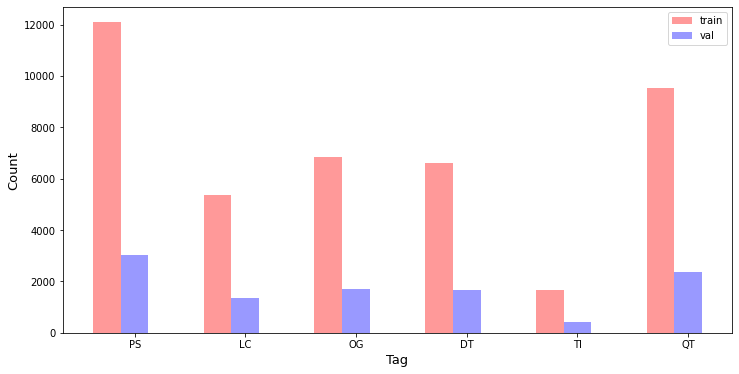

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

index = np.arange(6)

b1 = plt.bar(index, tag_cnt_df['train'], bar_width, alpha=0.4, color='red', label='train')

b2 = plt.bar(index + bar_width, tag_cnt_df['val'], bar_width, alpha=0.4, color='blue', label='val')

plt.xticks(np.arange(bar_width, 6 + bar_width, 1), tags)

plt.xlabel('Tag', size = 13)
plt.ylabel('Count', size = 13)
plt.legend()
plt.show()

## [2] 태그 개수 분포 확인
> 태그가 많이 포함된 데이터가 어느 한쪽으로 쏠리는 현상 없이 학습 데이터와 검증 데이터 간 태그 개수 분포가 유사하게 분리된 걸 확인할 수 있습니다.

In [19]:
train_len_dict, val_len_dict = defaultdict(int), defaultdict(int)

for tags in train["tags"]:
    train_len_dict[len(tags)] += 1
        
for tags in val["tags"]:
    val_len_dict[len(tags)] += 1
    
print(train_len_dict)
print(val_len_dict)

defaultdict(<class 'int'>, {1: 6243, 2: 4229, 3: 2547, 4: 1752, 5: 797, 6: 538, 7: 296, 8: 152, 9: 84, 10: 48, 11: 30, 12: 17, 13: 9, 14: 6, 15: 3, 16: 4, 18: 3, 19: 1, 20: 1, 23: 1})
defaultdict(<class 'int'>, {1: 2220, 2: 643, 3: 185, 4: 45, 5: 320, 6: 239, 7: 177, 8: 82, 9: 60, 10: 33, 11: 15, 12: 9, 13: 2, 14: 4, 15: 3, 16: 1, 19: 1, 20: 2})


In [20]:
for idx in range(1,24):
    if idx not in train_len_dict.keys():
        train_len_dict[idx] = 0

for idx in range(1,24):
    if idx not in val_len_dict.keys():
        val_len_dict[idx] = 0
        
train_len_dict = dict(sorted(train_len_dict.items()))
val_len_dict = dict(sorted(val_len_dict.items()))

In [21]:
tag_N_cnt_df = pd.DataFrame({'train' : list(train_len_dict.values()), 'val' : list(val_len_dict.values())}, index = train_len_dict.keys())
tag_N_cnt_df

,train,val
1,6243,2220
2,4229,643
3,2547,185
4,1752,45
5,797,320
6,538,239
7,296,177
8,152,82
9,84,60
10,48,33


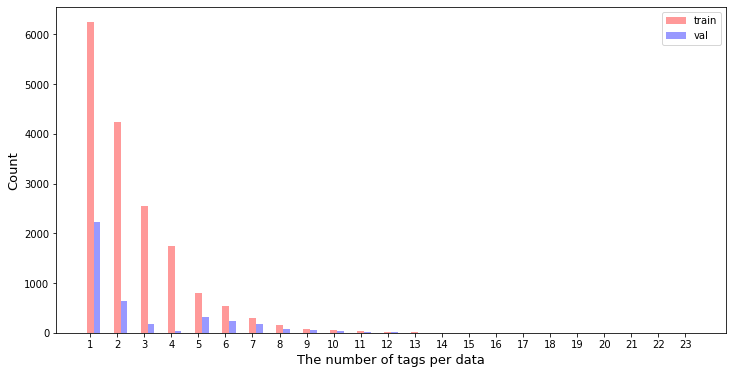

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

index = np.arange(1,24)

b1 = plt.bar(index,  train_len_dict.values(), bar_width, alpha=0.4, color='red', label='train')

b2 = plt.bar(index + bar_width, val_len_dict.values(), bar_width, alpha=0.4, color='blue', label='val')

plt.xticks(index, train_len_dict.keys())

plt.xlabel('The number of tags per data', size = 13)
plt.ylabel('Count', size = 13)
plt.legend()
plt.show()